In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image
import glob
from astropy.io import fits
import h5py

import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction
from DataMaker import *

keras.backend.set_image_data_format('channels_first')

2024-01-15 09:46:14.907475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 09:46:15.684867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-15 09:46:19.957826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 09:46:20.046209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 09:46:20.046470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
channels = 5
BATCH_SIZE = 32

TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing.hdf5'

gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)

In [5]:
timesteps = 1000
learning_rate = 1e-5
min_noise = 0.0001
max_noise = 0.02

# create a fixed beta schedule
beta = np.linspace(min_noise, max_noise, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will add noise to the input as per the given timestamp
def forward_noise(x_0, t):
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(num):
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

(5, 64, 64)


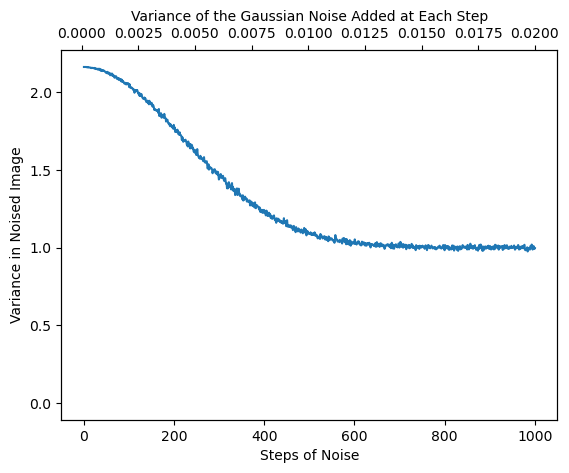

In [6]:
sample = train_gen[0][0][0]
print(sample.shape)
y_arr = np.array([])
for index, i in enumerate(range(timesteps)):
    noisy_im, noise = forward_noise(np.expand_dims(sample, 0), np.array([i, ]))
    y_arr = np.append(y_arr, np.var(noisy_im.flatten()))

x_arr = np.linspace(0, timesteps, timesteps)

fig, ax1 = plt.subplots()
ax1.plot(x_arr, y_arr)
ax1.set_xlabel("Steps of Noise")
ax1.set_ylabel("Variance in Noised Image")

ax2 = ax1.twiny()
ax2.plot(beta, 0 * np.ones(timesteps), alpha = 0) # Create a dummy plot
ax2.set_xlabel("Variance of the Gaussian Noise Added at Each Step")
plt.show()

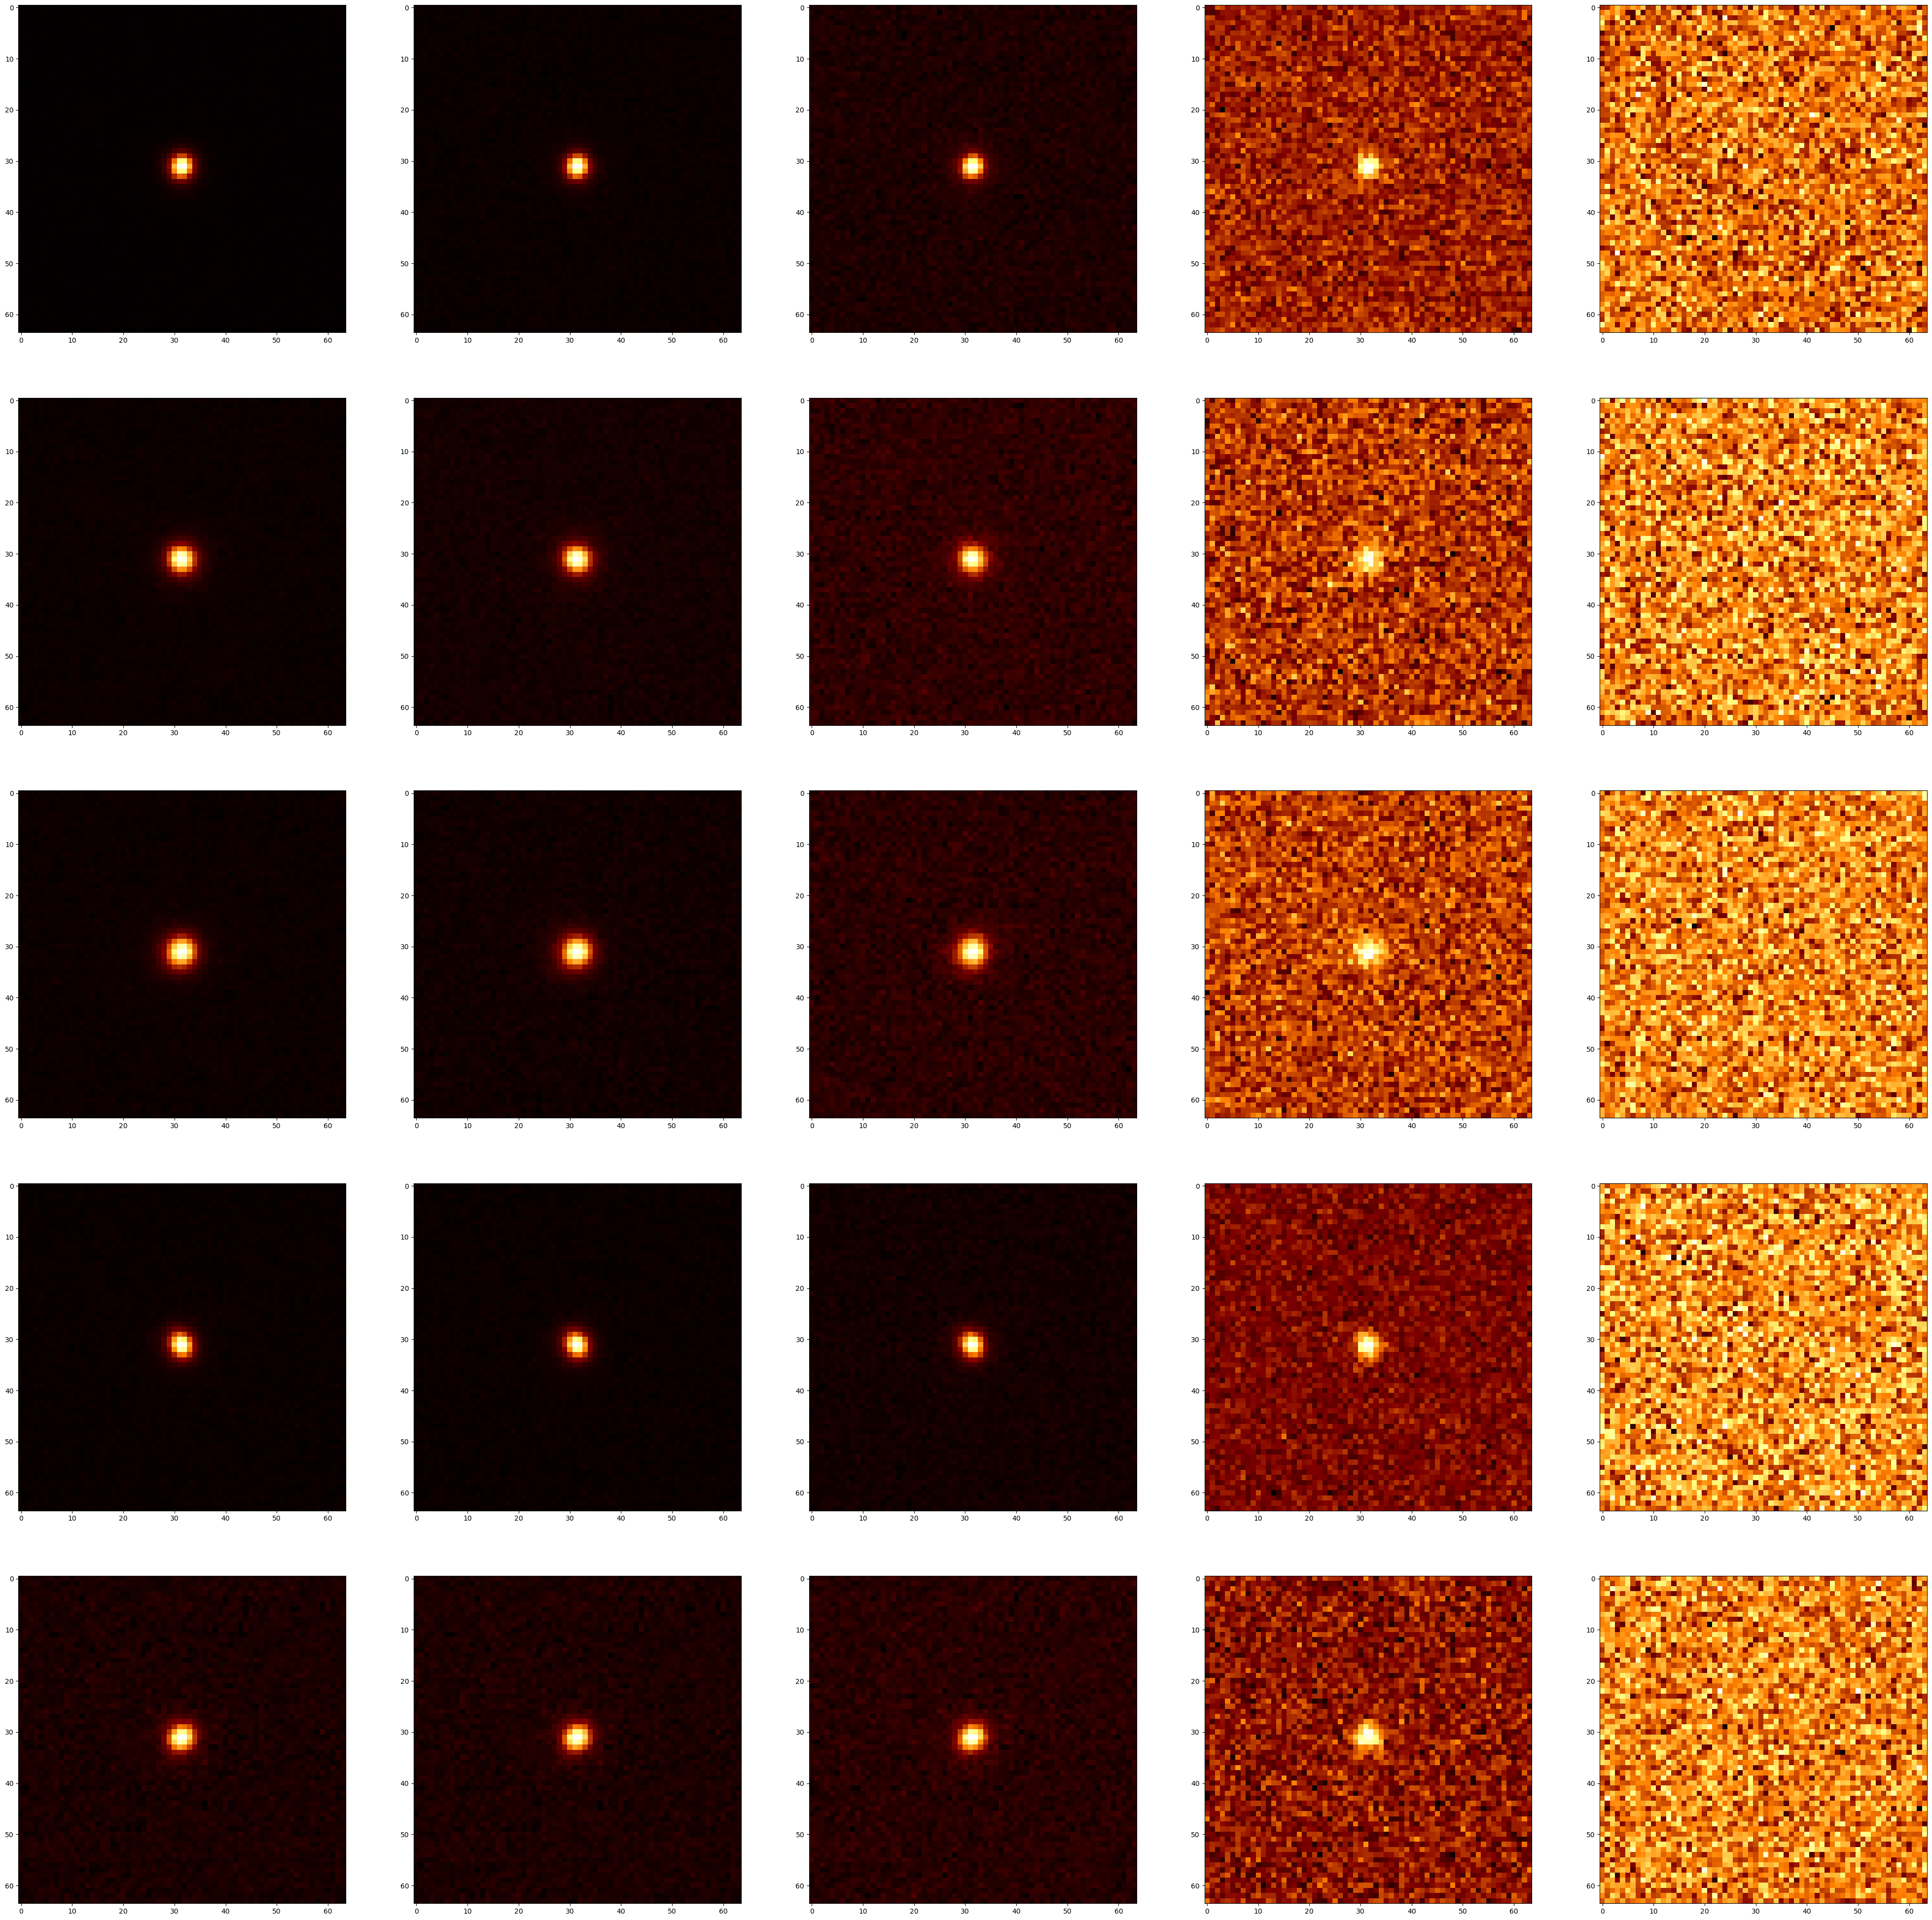

In [7]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (50, 50))

j = 0

for index, i in enumerate([0, 50, 150, 500, 999]):
    noisy_im, noise = forward_noise(np.expand_dims(sample, 0), np.array([i, ]))
    axes[0][j].imshow(noisy_im[0][0], cmap = 'afmhot')
    axes[1][j].imshow(noisy_im[0][1], cmap = 'afmhot')
    axes[2][j].imshow(noisy_im[0][2], cmap = 'afmhot')
    axes[3][j].imshow(noisy_im[0][3], cmap = 'afmhot')
    axes[4][j].imshow(noisy_im[0][4], cmap = 'afmhot')
    j += 1
    

plt.show()

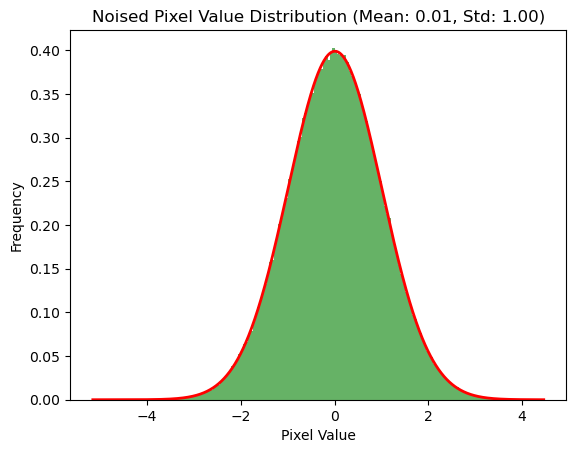

In [8]:
from scipy.stats import norm
from scipy.optimize import curve_fit

sample = train_gen[0][0]

noised_im, noise = forward_noise(sample, np.array([999, ]))
pixel_values = noised_im.ravel()
x_values = np.linspace(np.min(pixel_values), np.max(pixel_values), 1000)
# Calculate the normal distribution values for these x_values

bin_size = 0.05
bins = int((np.max(pixel_values) - np.min(pixel_values)) / bin_size)

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

histogram, bin_edges = np.histogram(pixel_values, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Fit the Gaussian distribution to the histogram data
popt, _ = curve_fit(gaussian, bin_centers, histogram, p0=[0, 1, 1])
fitted_mean, fitted_std = popt[0], popt[2]

# Plot histogram
plt.hist(pixel_values, bins=bins, density=True, alpha=0.6, color='g')

# normal_distribution = len(pixel_values) * probability_in_bin * norm.pdf(x_values, 0, 1)
plt.plot(x_values, gaussian(x_values, *popt), color='r', linewidth=2)

plt.title(f'Noised Pixel Value Distribution (Mean: {fitted_mean:.2f}, Std: {fitted_std:.2f})')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
# plt.xlim(-5, 5)
plt.show()

In [9]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, dim, 1, 1]))
        self.b = tf.Variable(tf.zeros([1, dim, 1, 1]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=1, keepdims=True)
        mean = tf.reduce_mean(x, axis=1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x
    
class LayerNormChannelsFirst(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNormChannelsFirst, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=-1, keepdims=True)
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training=True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

In [10]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05, axis=1)
        self.act = SiLU()


    def call(self, x, gamma_beta=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=1)

        h = self.block1(x, gamma_beta=gamma_beta, training=training)
        h = self.block2(h, training=training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False, data_format='channels_last')

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1, data_format='channels_last'),
            LayerNormChannelsFirst(dim)
        ])

    def call(self, x, training=True):
        
        x = tf.transpose(x, [0, 2, 3, 1])
        
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out, training=training)

        out = tf.transpose(out, [0, 3, 1, 2])
        return out
    
class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False, data_format='channels_last')
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1, data_format='channels_last')

    def call(self, x, training=True):
        
        x = tf.transpose(x, [0, 2, 3, 1])
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis=-1), axis=-1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis=-1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training=training)
        
        out = tf.transpose(out, [0, 3, 1, 2])
        return out
    
class Conditioning(Layer):
    def __init__(self, res, num_channels=5):
        super().__init__()
        self.block = Sequential([
            nn.Dense(num_channels * res * res),
            SiLU(),
            nn.Reshape((num_channels, res, res))
        ])

        self.block.compile()

    def call(self, x):
        return self.block(x)

In [11]:
class Unet_conditional(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=5,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True,
                 in_res=64
                 ):
        super(Unet_conditional, self).__init__()

        # determine dimensions
        self.channels = channels
        self.in_res = in_res

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        resnet_block_class = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                GELU(),
                nn.Dense(units=time_dim)
            ], name="time embeddings")

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                Conditioning(now_res),
                resnet_block_class(dim_in+1, dim_out, time_emb_dim=time_dim),
                resnet_block_class(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1

        mid_dim = dims[-1]
        self.mid_conditioning = Conditioning(now_res)
        self.mid_block1 = resnet_block_class(mid_dim+1, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = resnet_block_class(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                Conditioning(now_res),
                resnet_block_class((dim_out * 2) + 1, dim_in, time_emb_dim=time_dim),
                resnet_block_class(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            resnet_block_class(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")

    def call(self, x, time=None, redshift=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        
        h = []

        for conditioning, block1, block2, attn, downsample in self.downs:
            cv = conditioning(redshift)
            x = tf.concat([x, cv], axis=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        
        cv = self.mid_conditioning(redshift)
        x = tf.concat([x, cv], axis=1)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for conditioning, block1, block2, attn, upsample in self.ups:
            cv = conditioning(redshift)
            x = tf.concat([x, cv], axis=1)
            x = tf.concat([x, h.pop()], axis=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=1)
        x = self.final_conv(x)
        return x

In [12]:
unet = Unet_conditional(
    in_res=64,
    channels=5
)

test_images = np.ones([1, 5, 64, 64])
test_timestamps = generate_timestamp(1)
test_redshift = np.array([[1.0]])
k = unet(test_images, test_timestamps, test_redshift)
opt = keras.optimizers.Adam(learning_rate=learning_rate)

2024-01-10 22:28:29.824612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-01-10 22:28:29.968252: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 22:28:30.222964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [13]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [14]:
def train_step(batch, condition):
    timestep_values = generate_timestamp(batch.shape[0])

    noised_image, noise = forward_noise(batch, tf.cast(timestep_values, tf.int32))
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, condition)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

In [15]:
epochs = 10
save_frequency = 1

saved_weights_dir = "/data3/Billy/diffusion_saved_weights"
if not os.path.exists(saved_weights_dir):
    os.mkdir(saved_weights_dir)

# Load the latest saved weights, if any
latest_weights = sorted(glob.glob(f"{saved_weights_dir}/weights_epoch_*"))

if latest_weights:
    
    latest_epoch = int(latest_weights[-1].split('_')[-1].split('.')[0])  # Extract the epoch number from the filename
    unet.load_weights(latest_weights[-1].split('.')[0])
    print(f"Resuming from epoch {latest_epoch + 1}, loaded weights from {latest_weights[-1]}")
    
else:
    
    latest_epoch = -1  # Start from epoch 0
    print("Starting from epoch 0")

Resuming from epoch 27, loaded weights from /data3/Billy/diffusion_saved_weights/weights_epoch_26.index


In [ ]:
for e in range(latest_epoch + 1, epochs + latest_epoch + 1):
    bar = tf.keras.utils.Progbar(len(train_gen)-1)
    losses = []
    for i, batch in enumerate(iter(train_gen)):
        # run the training loop
        loss = train_step(batch[0], batch[1].reshape(-1, 1))
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])  

    avg = np.mean(losses)
    print(f"Average loss for epoch {e}/{epochs}: {avg}")
    
    if e % save_frequency == 0:
        
        weight_file_path = f"{saved_weights_dir}/weights_epoch_{e}"
        unet.save_weights(weight_file_path)
        print(f"Saved weights to {weight_file_path}")

In [16]:
def save_gif(img_list, path="", interval=200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        max = np.amax(np.nan_to_num(img_list))
        min = np.amin(np.nan_to_num(img_list))
        im = (im - min) / (max - min) * 255
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [17]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

for k in range(0, 5):
    z = k / 2 + 0.1
    x = tf.random.normal((1, 5, 64, 64))

    img_list_g = []
    img_list_r = []
    img_list_i = []
    img_list_z = []
    img_list_y = []
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])
    
    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z]]))
        x = ddpm(x, pred_noise, t)
        img_list_g.append(np.squeeze(x, 0)[0])
        img_list_r.append(np.squeeze(x, 0)[1])
        img_list_i.append(np.squeeze(x, 0)[2])
        img_list_z.append(np.squeeze(x, 0)[3])
        img_list_y.append(np.squeeze(x, 0)[4])
            

    save_gif(img_list_g + ([img_list_g[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_g.gif", interval = 20)
    save_gif(img_list_r + ([img_list_r[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_r.gif", interval = 20)
    save_gif(img_list_i + ([img_list_i[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_i.gif", interval = 20)
    save_gif(img_list_z + ([img_list_z[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_z.gif", interval = 20)
    save_gif(img_list_y + ([img_list_y[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_y.gif", interval = 20)

In [29]:
z = 0.1
seed = np.random.randint(0, 1000000)
print(seed)
x = tf.random.normal((1, 5, 64, 64), seed=seed)

img_list_g = []
img_list_r = []
img_list_i = []
img_list_z = []
img_list_y = []
img_list_g.append(np.squeeze(x, 0)[0])
img_list_r.append(np.squeeze(x, 0)[1])
img_list_i.append(np.squeeze(x, 0)[2])
img_list_z.append(np.squeeze(x, 0)[3])
img_list_y.append(np.squeeze(x, 0)[4])
    
for i in tqdm(range(timesteps - 1)):
    t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise = unet(x, t, np.array([[z]]))
    x = ddpm(x, pred_noise, t)
    img_list_g.append(np.squeeze(x, 0)[0])
    img_list_r.append(np.squeeze(x, 0)[1])
    img_list_i.append(np.squeeze(x, 0)[2])
    img_list_z.append(np.squeeze(x, 0)[3])
    img_list_y.append(np.squeeze(x, 0)[4])

920671


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


In [30]:
z_2 = 3
seed = np.random.randint(0, 1000000)
print(seed)
x_2 = tf.random.normal((1, 5, 64, 64), seed=seed)

img_list_g_2 = []
img_list_r_2 = []
img_list_i_2 = []
img_list_z_2 = []
img_list_y_2 = []
img_list_g_2.append(np.squeeze(x_2, 0)[0])
img_list_r_2.append(np.squeeze(x_2, 0)[1])
img_list_i_2.append(np.squeeze(x_2, 0)[2])
img_list_z_2.append(np.squeeze(x_2, 0)[3])
img_list_y_2.append(np.squeeze(x_2, 0)[4])
    
for i in tqdm(range(timesteps - 1)):
    t_2 = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise_2 = unet(x_2, t_2, np.array([[z_2]]))
    x_2 = ddpm(x_2, pred_noise_2, t_2)
    img_list_g_2.append(np.squeeze(x_2, 0)[0])
    img_list_r_2.append(np.squeeze(x_2, 0)[1])
    img_list_i_2.append(np.squeeze(x_2, 0)[2])
    img_list_z_2.append(np.squeeze(x_2, 0)[3])
    img_list_y_2.append(np.squeeze(x_2, 0)[4])

675479


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


(0.0, 2.0)

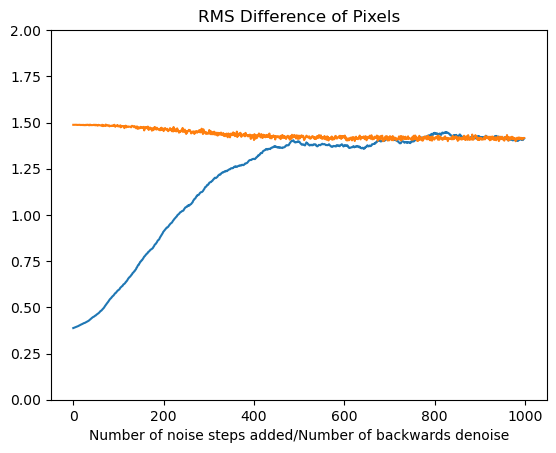

In [31]:
y_array = []
for i in range(999):
    rms = np.sqrt(np.mean((img_list_g[i].ravel() - img_list_g_2[i].ravel()) ** 2))
    y_array.insert(0, rms)
y_array_2 = []
sample = train_gen[0][0][0]
sample_2 = train_gen[0][0][1]
for i in range(999):
    noisy_im_1, noise_1 = forward_noise(np.expand_dims(sample, 0), np.array([i, ]))
    noisy_im_2, noise_2 = forward_noise(np.expand_dims(sample_2, 0), np.array([i, ]))
    rms = np.sqrt(np.mean((noisy_im_1.ravel() - noisy_im_2.ravel()) ** 2))
    y_array_2.append(rms)
x_array = range(999)
plt.plot(x_array, y_array, label = 'DDPM')
plt.plot(x_array, y_array_2, label = 'Original')
plt.title('RMS Difference of Pixels')
plt.xlabel('Number of noise steps added/Number of backwards denoise')
plt.ylim(0, 2)

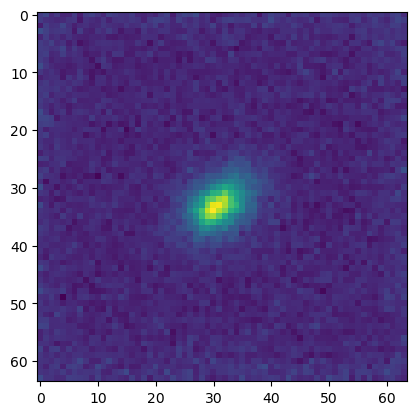

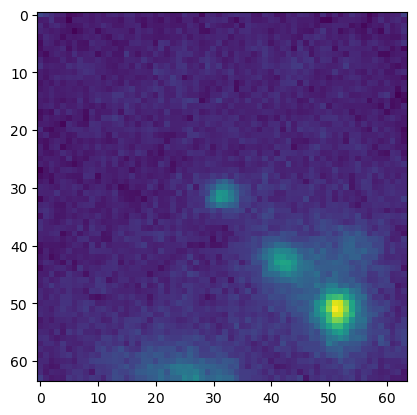

In [32]:
plt.imshow(img_list_g[999])
plt.show()
plt.imshow(img_list_g_2[999])
plt.show()

random_keys = np.random.randint(0, 1000000, 2000)
random_redshift = np.random.uniform(0, 4, 2000)

np.save('/data/HSC_generated/HSC_generated_v1/random_keys.npy', random_keys)
np.save('/data/HSC_generated/HSC_generated_v1/random_redshift.npy', random_redshift)

In [18]:
random_keys = np.load('/data/HSC_generated/HSC_generated_v1/random_keys.npy')
random_redshift = np.load('/data/HSC_generated/HSC_generated_v1/random_redshift.npy')

In [21]:
total = 2000

hf = h5py.File('/data/HSC_generated/HSC_generated_v1/ddpm/64x64/5x64x64_testing.hdf5', 'a')

fits_dir = "/data/HSC_generated/HSC_generated_v1/ddpm/"
if not os.path.exists(fits_dir):
    os.mkdir(fits_dir)

# Load the latest saved weights, if any
latest_generated = sorted(glob.glob(f"{fits_dir}/y_band_ddpm/ddpm_y_band_*.fits"))

if latest_generated:
    
    latest_gen = int(latest_generated[-1].split('_')[-1].split('.')[0]) - 1
    print(f"Resuming to generate image {latest_gen + 1}, overwriting current image {latest_gen + 1} (to prevent fits corruption).")
    
else:
    
    latest_gen = 0  # Start from epoch 0
    print("Generating image 1")

for number_generated in range(latest_gen, total):
    z = random_redshift[number_generated]
    seed = random_keys[number_generated]
    x = tf.random.normal((1, 5, 64, 64), seed=seed)

    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, t, np.array([[z]]))
        x = ddpm(x, pred_noise, t)
    
    g_band = np.squeeze(x, 0)[0]
    r_band = np.squeeze(x, 0)[1]
    i_band = np.squeeze(x, 0)[2]
    z_band = np.squeeze(x, 0)[3]
    y_band = np.squeeze(x, 0)[4]
    
    hdul = fits.PrimaryHDU(data = g_band)
    string = f"{fits_dir}/g_band_ddpm/ddpm_g_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    hdul = fits.PrimaryHDU(data = r_band)
    string = f"{fits_dir}/r_band_ddpm/ddpm_r_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    hdul = fits.PrimaryHDU(data = i_band)
    string = f"{fits_dir}/i_band_ddpm/ddpm_i_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    hdul = fits.PrimaryHDU(data = z_band)
    string = f"{fits_dir}/z_band_ddpm/ddpm_z_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    hdul = fits.PrimaryHDU(data = y_band)
    string = f"{fits_dir}/y_band_ddpm/ddpm_y_band_{number_generated + 1}.fits"
    hdul.writeto(string, overwrite = True)
    
    five_band_image = []
    five_band_image.append(g_band)
    five_band_image.append(r_band)
    five_band_image.append(i_band)
    five_band_image.append(z_band)
    five_band_image.append(y_band)
    
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    
    if number_generated > 0:
        
        hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
        hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
        hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
        hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
    
    else:
        
        hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
        hf.create_dataset('specz_redshift', data = [z], chunks = True, maxshape = (None, ))
    
    print(f"Saved fits number {number_generated + 1} to {fits_dir}")
    
hf.close()

Generating image 1


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 2 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 3 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 4 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 5 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 6 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 7 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 8 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 9 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 10 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 11 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 12 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 13 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 14 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 15 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 16 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 17 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 18 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 19 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 20 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 21 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 22 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 23 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 24 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 25 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.75it/s]


Saved fits number 26 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 27 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 28 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 29 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 30 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 31 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 32 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 33 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 34 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 35 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 36 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 37 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 38 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 39 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 40 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 41 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 42 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 43 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 44 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 45 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 46 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 47 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 48 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 49 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 50 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 51 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 52 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 53 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 54 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 55 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 56 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 57 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 58 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 59 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.77it/s]


Saved fits number 60 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 61 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 62 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 63 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 64 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 65 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 66 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 67 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 68 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 69 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 70 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 71 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 72 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 73 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 74 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 75 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 76 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 77 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.70it/s]


Saved fits number 78 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 79 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 80 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 81 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 82 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 83 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 84 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 85 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 86 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 87 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 88 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 89 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 90 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 91 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 92 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 93 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 94 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 95 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 96 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 97 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 98 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:26<00:00,  6.82it/s]


Saved fits number 99 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 100 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 101 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 102 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 103 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 104 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 105 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.77it/s]


Saved fits number 106 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 107 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 108 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 109 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 110 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 111 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 112 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 113 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 114 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 115 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 116 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 117 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 118 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.75it/s]


Saved fits number 119 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 120 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 121 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 122 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 123 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 124 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 125 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 126 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 127 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 128 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 129 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 130 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 131 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 132 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 133 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 134 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 135 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 136 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 137 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 138 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 139 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 140 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 141 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 142 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 143 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 144 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 145 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 146 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 147 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 148 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 149 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 150 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 151 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 152 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 153 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 154 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 155 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 156 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 157 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 158 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 159 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 160 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 161 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 162 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.75it/s]


Saved fits number 163 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 164 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 165 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 166 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 167 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 168 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 169 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 170 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 171 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 172 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 173 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 174 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 175 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 176 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 177 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 178 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 179 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 180 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 181 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 182 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 183 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 184 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 185 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 186 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 187 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 188 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 189 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 190 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 191 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 192 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 193 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 194 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 195 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 196 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 197 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 198 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 199 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 200 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 201 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 202 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 203 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 204 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 205 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 206 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 207 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 208 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 209 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 210 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 211 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 212 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 213 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 214 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 215 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 216 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 217 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 218 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 219 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 220 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 221 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 222 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 223 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 224 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 225 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 226 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 227 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 228 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 229 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 230 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 231 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 232 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 233 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 234 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 235 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 236 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 237 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 238 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 239 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 240 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 241 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 242 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 243 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 244 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 245 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 246 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 247 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 248 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 249 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 250 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 251 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 252 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 253 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 254 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 255 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 256 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 257 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 258 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 259 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 260 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 261 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 262 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 263 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 264 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 265 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 266 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 267 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 268 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 269 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 270 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 271 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 272 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 273 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 274 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 275 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 276 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 277 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 278 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 279 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 280 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 281 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 282 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 283 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 284 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 285 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 286 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 287 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 288 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 289 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 290 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 291 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 292 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 293 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 294 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 295 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.75it/s]


Saved fits number 296 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 297 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 298 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 299 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 300 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.77it/s]


Saved fits number 301 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.76it/s]


Saved fits number 302 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 303 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 304 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 305 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 306 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.75it/s]


Saved fits number 307 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.76it/s]


Saved fits number 308 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 309 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 310 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 311 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.79it/s]


Saved fits number 312 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.76it/s]


Saved fits number 313 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 314 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 315 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 316 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.79it/s]


Saved fits number 317 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 318 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 319 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 320 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 321 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.79it/s]


Saved fits number 322 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 323 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 324 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 325 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 326 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 327 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 328 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 329 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 330 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 331 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 332 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 333 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 334 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 335 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 336 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 337 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 338 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 339 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 340 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 341 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.77it/s]


Saved fits number 342 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 343 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 344 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 345 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 346 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 347 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 348 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 349 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 350 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 351 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 352 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 353 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 354 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 355 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 356 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 357 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 358 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 359 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 360 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 361 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 362 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.78it/s]


Saved fits number 363 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 364 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 365 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 366 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 367 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 368 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 369 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.78it/s]


Saved fits number 370 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 371 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 372 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 373 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 374 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 375 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 376 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 377 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 378 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 379 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 380 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 381 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.78it/s]


Saved fits number 382 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:26<00:00,  6.82it/s]


Saved fits number 383 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.75it/s]


Saved fits number 384 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 385 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 386 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 387 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 388 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 389 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 390 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.75it/s]


Saved fits number 391 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 392 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 393 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 394 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 395 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 396 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 397 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 398 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:27<00:00,  6.75it/s]


Saved fits number 399 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 400 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 401 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 402 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 403 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 404 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 405 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 406 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 407 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 408 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 409 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 410 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 411 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 412 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 413 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 414 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 415 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 416 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 417 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 418 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 419 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 420 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 421 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 422 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 423 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 424 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 425 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 426 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 427 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 428 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 429 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 430 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 431 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 432 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 433 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 434 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 435 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 436 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 437 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 438 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 439 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 440 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 441 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 442 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 443 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 444 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 445 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 446 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 447 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 448 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 449 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 450 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 451 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 452 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 453 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 454 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 455 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 456 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 457 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 458 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 459 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 460 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 461 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 462 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 463 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 464 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 465 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 466 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 467 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 468 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 469 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 470 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 471 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 472 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 473 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 474 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 475 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 476 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 477 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 478 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 479 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 480 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 481 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 482 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.49it/s]


Saved fits number 483 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 484 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 485 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 486 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 487 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 488 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 489 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 490 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 491 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 492 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 493 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 494 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 495 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 496 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 497 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 498 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 499 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 500 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 501 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 502 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 503 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 504 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 505 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 506 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 507 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 508 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 509 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 510 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 511 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 512 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 513 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 514 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 515 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 516 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 517 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 518 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 519 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 520 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 521 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 522 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 523 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 524 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 525 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 526 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 527 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 528 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 529 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 530 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 531 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 532 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 533 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 534 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 535 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 536 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.62it/s]


Saved fits number 537 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 538 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 539 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 540 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 541 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 542 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 543 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 544 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 545 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 546 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 547 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 548 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 549 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 550 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 551 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 552 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 553 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 554 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 555 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 556 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 557 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 558 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 559 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 560 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 561 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 562 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 563 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.62it/s]


Saved fits number 564 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 565 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 566 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 567 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 568 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 569 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 570 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 571 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 572 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 573 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 574 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 575 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 576 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 577 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 578 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 579 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 580 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 581 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 582 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 583 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 584 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 585 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 586 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 587 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 588 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 589 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 590 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 591 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 592 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 593 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 594 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 595 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 596 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 597 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 598 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 599 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 600 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 601 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 602 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 603 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 604 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 605 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 606 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 607 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 608 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 609 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 610 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 611 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 612 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 613 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 614 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 615 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 616 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 617 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.36it/s]


Saved fits number 618 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 619 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 620 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 621 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 622 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 623 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 624 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 625 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 626 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 627 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 628 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 629 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 630 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 631 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 632 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 633 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 634 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 635 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 636 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 637 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 638 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 639 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 640 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 641 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 642 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 643 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 644 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 645 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 646 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 647 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 648 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 649 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 650 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 651 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 652 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 653 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 654 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 655 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 656 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 657 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 658 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 659 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 660 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 661 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 662 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 663 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 664 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 665 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 666 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 667 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 668 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 669 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 670 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 671 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 672 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 673 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 674 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 675 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 676 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 677 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 678 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 679 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 680 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 681 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 682 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 683 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 684 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 685 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 686 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 687 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 688 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 689 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 690 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 691 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 692 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 693 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 694 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 695 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 696 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 697 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 698 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 699 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 700 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 701 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.49it/s]


Saved fits number 702 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 703 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 704 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 705 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 706 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 707 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 708 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 709 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 710 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 711 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 712 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 713 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 714 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 715 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 716 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 717 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 718 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 719 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 720 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 721 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 722 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 723 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 724 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 725 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 726 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 727 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 728 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 729 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 730 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 731 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 732 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 733 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 734 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 735 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 736 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 737 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 738 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 739 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 740 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 741 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 742 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 743 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 744 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 745 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 746 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 747 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 748 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 749 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 750 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 751 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 752 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 753 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 754 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 755 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 756 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 757 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 758 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 759 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 760 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 761 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 762 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 763 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 764 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 765 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 766 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 767 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 768 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 769 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 770 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 771 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 772 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 773 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 774 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 775 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 776 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 777 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 778 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 779 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 780 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 781 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 782 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 783 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 784 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 785 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 786 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 787 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 788 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 789 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 790 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 791 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.49it/s]


Saved fits number 792 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 793 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 794 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 795 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 796 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 797 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 798 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 799 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 800 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 801 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 802 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 803 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 804 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 805 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 806 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 807 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 808 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 809 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 810 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 811 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 812 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 813 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 814 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 815 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 816 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 817 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 818 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 819 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 820 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 821 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 822 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 823 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 824 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 825 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 826 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 827 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 828 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 829 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 830 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 831 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 832 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 833 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 834 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 835 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 836 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 837 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 838 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 839 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 840 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 841 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 842 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 843 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 844 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 845 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 846 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 847 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 848 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 849 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 850 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 851 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 852 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 853 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 854 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 855 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 856 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 857 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 858 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 859 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 860 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 861 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 862 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 863 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 864 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 865 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 866 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 867 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 868 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 869 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 870 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 871 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 872 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 873 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 874 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 875 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 876 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 877 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 878 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 879 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 880 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 881 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 882 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 883 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 884 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 885 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 886 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 887 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 888 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 889 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 890 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 891 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 892 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 893 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 894 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 895 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 896 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 897 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 898 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 899 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 900 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 901 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 902 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 903 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 904 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 905 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 906 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 907 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 908 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 909 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 910 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 911 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 912 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 913 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 914 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 915 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 916 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 917 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 918 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 919 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.49it/s]


Saved fits number 920 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 921 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 922 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 923 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 924 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 925 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 926 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 927 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 928 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 929 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 930 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 931 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 932 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 933 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 934 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 935 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 936 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 937 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 938 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 939 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 940 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 941 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 942 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 943 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 944 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 945 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 946 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 947 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 948 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 949 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 950 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 951 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 952 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 953 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 954 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 955 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 956 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 957 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 958 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 959 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.49it/s]


Saved fits number 960 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 961 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 962 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 963 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 964 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 965 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 966 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 967 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 968 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 969 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:44<00:00,  6.08it/s]


Saved fits number 970 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.13it/s]


Saved fits number 971 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 972 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 973 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 974 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 975 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 976 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 977 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 978 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 979 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 980 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 981 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 982 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 983 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 984 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 985 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 986 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 987 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 988 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 989 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 990 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 991 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 992 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 993 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 994 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 995 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 996 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 997 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 998 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 999 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 1000 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1001 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1002 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1003 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1004 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1005 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1006 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1007 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.36it/s]


Saved fits number 1008 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1009 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1010 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1011 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1012 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1013 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1014 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1015 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1016 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1017 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 1018 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 1019 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.62it/s]


Saved fits number 1020 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 1021 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1022 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 1023 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 1024 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1025 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 1026 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1027 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1028 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1029 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1030 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1031 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1032 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1033 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1034 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 1035 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1036 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1037 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 1038 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1039 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1040 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 1041 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 1042 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 1043 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1044 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 1045 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1046 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1047 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1048 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1049 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1050 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 1051 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1052 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1053 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1054 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 1055 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 1056 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1057 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1058 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 1059 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1060 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1061 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1062 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1063 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1064 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1065 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 1066 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1067 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1068 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 1069 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1070 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 1071 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1072 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1073 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1074 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.49it/s]


Saved fits number 1075 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 1076 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 1077 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 1078 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1079 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1080 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 1081 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1082 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1083 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1084 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 1085 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 1086 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1087 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1088 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1089 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1090 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1091 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 1092 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1093 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1094 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1095 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1096 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1097 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1098 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 1099 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 1100 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.62it/s]


Saved fits number 1101 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1102 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1103 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 1104 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 1105 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 1106 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1107 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1108 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1109 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 1110 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.62it/s]


Saved fits number 1111 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1112 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1113 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 1114 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1115 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 1116 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 1117 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1118 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1119 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1120 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1121 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 1122 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1123 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 1124 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1125 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 1126 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1127 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1128 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.17it/s]


Saved fits number 1129 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1130 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1131 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1132 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1133 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1134 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1135 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1136 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1137 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1138 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1139 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1140 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1141 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 1142 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1143 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1144 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1145 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1146 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.24it/s]


Saved fits number 1147 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1148 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1149 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.24it/s]


Saved fits number 1150 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1151 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1152 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1153 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1154 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1155 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1156 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1157 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1158 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1159 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1160 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1161 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1162 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1163 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1164 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1165 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1166 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1167 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1168 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1169 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1170 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1171 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1172 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1173 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1174 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1175 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1176 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1177 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1178 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1179 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1180 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1181 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1182 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1183 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1184 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1185 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1186 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1187 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1188 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1189 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1190 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1191 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1192 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.32it/s]


Saved fits number 1193 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1194 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1195 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1196 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1197 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1198 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1199 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1200 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1201 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1202 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1203 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1204 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1205 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1206 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1207 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1208 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1209 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1210 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1211 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1212 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1213 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1214 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1215 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1216 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1217 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1218 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1219 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1220 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1221 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1222 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1223 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1224 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1225 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1226 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1227 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1228 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1229 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1230 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1231 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:43<00:00,  6.11it/s]


Saved fits number 1232 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1233 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1234 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1235 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1236 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1237 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1238 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1239 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1240 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1241 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1242 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1243 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1244 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1245 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1246 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1247 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1248 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1249 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1250 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1251 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1252 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1253 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 1254 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1255 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1256 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1257 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1258 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1259 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 1260 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1261 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1262 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1263 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1264 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1265 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1266 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1267 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1268 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1269 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1270 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1271 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1272 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1273 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1274 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1275 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1276 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 1277 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1278 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1279 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1280 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1281 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1282 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1283 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1284 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1285 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1286 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1287 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.15it/s]


Saved fits number 1288 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1289 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1290 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1291 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1292 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1293 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1294 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1295 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1296 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1297 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1298 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1299 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1300 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1301 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1302 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1303 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1304 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1305 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1306 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1307 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1308 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1309 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1310 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1311 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1312 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1313 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1314 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1315 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1316 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1317 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1318 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1319 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1320 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1321 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1322 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1323 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1324 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1325 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1326 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1327 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1328 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1329 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1330 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1331 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1332 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1333 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1334 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1335 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1336 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1337 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1338 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1339 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1340 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.17it/s]


Saved fits number 1341 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1342 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1343 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1344 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1345 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1346 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1347 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1348 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1349 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.32it/s]


Saved fits number 1350 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1351 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1352 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1353 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1354 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1355 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1356 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1357 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:45<00:00,  6.04it/s]


Saved fits number 1358 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:45<00:00,  6.02it/s]


Saved fits number 1359 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.15it/s]


Saved fits number 1360 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:43<00:00,  6.13it/s]


Saved fits number 1361 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1362 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1363 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1364 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1365 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1366 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1367 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1368 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1369 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1370 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1371 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1372 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1373 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1374 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1375 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1376 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.13it/s]


Saved fits number 1377 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1378 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1379 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1380 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1381 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1382 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1383 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1384 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1385 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1386 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1387 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1388 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1389 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1390 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1391 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1392 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1393 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1394 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1395 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1396 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1397 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.15it/s]


Saved fits number 1398 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1399 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1400 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 1401 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1402 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1403 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1404 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1405 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1406 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1407 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1408 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1409 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1410 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1411 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1412 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1413 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1414 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1415 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1416 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1417 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1418 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1419 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1420 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.15it/s]


Saved fits number 1421 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1422 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1423 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1424 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1425 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1426 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1427 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1428 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1429 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1430 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1431 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1432 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1433 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1434 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1435 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1436 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1437 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1438 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1439 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1440 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1441 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1442 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1443 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1444 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1445 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1446 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1447 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1448 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1449 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1450 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1451 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1452 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1453 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1454 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1455 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1456 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1457 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1458 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1459 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1460 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1461 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1462 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:43<00:00,  6.12it/s]


Saved fits number 1463 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:44<00:00,  6.06it/s]


Saved fits number 1464 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:43<00:00,  6.11it/s]


Saved fits number 1465 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:43<00:00,  6.13it/s]


Saved fits number 1466 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1467 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1468 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1469 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1470 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1471 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1472 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1473 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1474 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1475 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1476 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1477 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1478 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1479 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1480 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1481 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1482 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1483 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1484 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:43<00:00,  6.11it/s]


Saved fits number 1485 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.14it/s]


Saved fits number 1486 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1487 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1488 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1489 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1490 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1491 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1492 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1493 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1494 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1495 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1496 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1497 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1498 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1499 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.15it/s]


Saved fits number 1500 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1501 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1502 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1503 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1504 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1505 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1506 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1507 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1508 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1509 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1510 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.32it/s]


Saved fits number 1511 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.40it/s]


Saved fits number 1512 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 1513 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 1514 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.36it/s]


Saved fits number 1515 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1516 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1517 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1518 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 1519 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1520 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1521 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1522 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1523 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 1524 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1525 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1526 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1527 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1528 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1529 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1530 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1531 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1532 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1533 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1534 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1535 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1536 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1537 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1538 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1539 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1540 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1541 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1542 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1543 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1544 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1545 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1546 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1547 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1548 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.17it/s]


Saved fits number 1549 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1550 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1551 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1552 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1553 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1554 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1555 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1556 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1557 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1558 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1559 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1560 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1561 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.15it/s]


Saved fits number 1562 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1563 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1564 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1565 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1566 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.32it/s]


Saved fits number 1567 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1568 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1569 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1570 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.36it/s]


Saved fits number 1571 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1572 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1573 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1574 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1575 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1576 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1577 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1578 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1579 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1580 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1581 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1582 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1583 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1584 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1585 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1586 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1587 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1588 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1589 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 1590 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1591 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1592 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1593 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1594 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1595 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1596 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1597 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1598 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1599 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1600 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.17it/s]


Saved fits number 1601 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1602 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1603 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1604 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1605 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1606 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.17it/s]


Saved fits number 1607 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1608 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1609 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1610 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1611 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1612 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1613 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1614 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1615 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1616 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1617 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.24it/s]


Saved fits number 1618 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1619 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1620 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1621 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1622 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1623 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1624 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1625 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1626 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1627 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1628 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1629 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1630 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 1631 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1632 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 1633 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1634 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1635 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1636 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1637 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1638 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1639 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1640 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.57it/s]


Saved fits number 1641 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1642 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1643 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1644 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 1645 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 1646 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 1647 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1648 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1649 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1650 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1651 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 1652 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 1653 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1654 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1655 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.53it/s]


Saved fits number 1656 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1657 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1658 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1659 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1660 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1661 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.53it/s]


Saved fits number 1662 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.49it/s]


Saved fits number 1663 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1664 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1665 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1666 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 1667 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1668 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 1669 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 1670 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 1671 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 1672 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1673 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 1674 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 1675 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1676 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 1677 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1678 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1679 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1680 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 1681 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1682 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1683 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 1684 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 1685 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 1686 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1687 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 1688 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 1689 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 1690 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 1691 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 1692 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1693 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1694 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 1695 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1696 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1697 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1698 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1699 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1700 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 1701 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1702 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 1703 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.51it/s]


Saved fits number 1704 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.54it/s]


Saved fits number 1705 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1706 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.64it/s]


Saved fits number 1707 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 1708 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


Saved fits number 1709 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1710 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1711 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1712 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1713 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.59it/s]


Saved fits number 1714 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1715 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 1716 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1717 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 1718 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1719 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.72it/s]


Saved fits number 1720 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 1721 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 1722 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 1723 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.67it/s]


Saved fits number 1724 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]


Saved fits number 1725 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1726 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.55it/s]


Saved fits number 1727 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.58it/s]


Saved fits number 1728 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:31<00:00,  6.60it/s]


Saved fits number 1729 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.57it/s]


Saved fits number 1730 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1731 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:32<00:00,  6.56it/s]


Saved fits number 1732 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 1733 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 1734 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.63it/s]


Saved fits number 1735 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.66it/s]


Saved fits number 1736 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


Saved fits number 1737 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.62it/s]


Saved fits number 1738 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.65it/s]


Saved fits number 1739 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.73it/s]


Saved fits number 1740 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 1741 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:28<00:00,  6.71it/s]


Saved fits number 1742 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:30<00:00,  6.66it/s]


Saved fits number 1743 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.69it/s]


Saved fits number 1744 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:29<00:00,  6.70it/s]


Saved fits number 1745 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1746 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1747 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1748 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1749 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1750 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1751 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1752 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1753 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1754 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1755 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1756 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.32it/s]


Saved fits number 1757 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1758 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1759 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1760 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1761 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1762 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1763 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1764 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1765 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1766 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1767 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1768 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1769 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1770 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1771 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1772 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1773 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1774 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1775 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1776 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1777 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1778 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1779 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1780 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1781 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1782 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1783 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1784 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1785 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1786 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1787 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1788 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1789 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1790 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1791 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1792 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1793 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1794 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1795 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.36it/s]


Saved fits number 1796 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1797 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1798 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1799 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1800 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1801 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1802 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1803 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1804 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1805 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1806 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1807 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1808 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.50it/s]


Saved fits number 1809 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.45it/s]


Saved fits number 1810 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1811 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1812 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1813 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1814 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1815 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1816 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1817 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1818 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1819 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1820 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1821 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1822 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1823 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1824 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1825 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1826 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1827 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1828 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1829 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1830 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.15it/s]


Saved fits number 1831 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1832 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1833 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1834 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1835 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1836 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1837 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1838 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1839 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1840 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1841 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1842 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1843 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1844 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1845 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1846 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1847 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1848 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1849 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1850 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.44it/s]


Saved fits number 1851 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1852 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1853 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1854 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1855 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1856 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1857 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1858 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1859 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.40it/s]


Saved fits number 1860 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1861 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1862 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1863 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1864 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1865 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1866 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1867 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1868 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1869 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1870 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.45it/s]


Saved fits number 1871 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1872 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1873 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1874 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.48it/s]


Saved fits number 1875 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1876 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1877 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1878 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1879 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1880 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1881 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1882 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1883 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1884 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1885 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1886 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1887 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.43it/s]


Saved fits number 1888 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1889 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1890 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1891 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1892 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1893 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1894 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1895 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1896 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1897 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:33<00:00,  6.52it/s]


Saved fits number 1898 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1899 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1900 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 1901 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1902 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1903 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1904 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1905 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1906 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1907 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1908 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1909 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1910 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1911 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.47it/s]


Saved fits number 1912 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:34<00:00,  6.46it/s]


Saved fits number 1913 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.42it/s]


Saved fits number 1914 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.40it/s]


Saved fits number 1915 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1916 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1917 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.41it/s]


Saved fits number 1918 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1919 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1920 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.39it/s]


Saved fits number 1921 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1922 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1923 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1924 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:35<00:00,  6.40it/s]


Saved fits number 1925 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1926 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.37it/s]


Saved fits number 1927 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1928 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1929 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1930 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1931 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1932 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1933 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1934 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.14it/s]


Saved fits number 1935 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:43<00:00,  6.11it/s]


Saved fits number 1936 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.14it/s]


Saved fits number 1937 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.17it/s]


Saved fits number 1938 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1939 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1940 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.36it/s]


Saved fits number 1941 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1942 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:36<00:00,  6.38it/s]


Saved fits number 1943 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1944 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1945 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1946 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:46<00:00,  5.99it/s]


Saved fits number 1947 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1948 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1949 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1950 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1951 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1952 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1953 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1954 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1955 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1956 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1957 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1958 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1959 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1960 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1961 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1962 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.18it/s]


Saved fits number 1963 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1964 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.31it/s]


Saved fits number 1965 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1966 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1967 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1968 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.30it/s]


Saved fits number 1969 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.34it/s]


Saved fits number 1970 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1971 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1972 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1973 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.24it/s]


Saved fits number 1974 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1975 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.28it/s]


Saved fits number 1976 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1977 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.17it/s]


Saved fits number 1978 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1979 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.29it/s]


Saved fits number 1980 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.15it/s]


Saved fits number 1981 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.21it/s]


Saved fits number 1982 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1983 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1984 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1985 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.19it/s]


Saved fits number 1986 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.25it/s]


Saved fits number 1987 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.22it/s]


Saved fits number 1988 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.35it/s]


Saved fits number 1989 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:42<00:00,  6.16it/s]


Saved fits number 1990 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.32it/s]


Saved fits number 1991 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1992 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:38<00:00,  6.28it/s]


Saved fits number 1993 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 1994 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.36it/s]


Saved fits number 1995 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.26it/s]


Saved fits number 1996 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:40<00:00,  6.23it/s]


Saved fits number 1997 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:41<00:00,  6.20it/s]


Saved fits number 1998 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:39<00:00,  6.27it/s]


Saved fits number 1999 to /data/HSC_generated/HSC_generated_v1/ddpm/


100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


Saved fits number 2000 to /data/HSC_generated/HSC_generated_v1/ddpm/


In [3]:
random_keys = np.load('/data/HSC_generated/HSC_generated_v1/random_keys.npy')
random_redshift = np.load('/data/HSC_generated/HSC_generated_v1/random_redshift.npy')

In [5]:
# If hdf5 creation failed

total = 2000

hf = h5py.File('/data/HSC_generated/HSC_generated_v1/ddpm/64x64/5x64x64_testing.hdf5', 'a')

fits_dir = "/data/HSC_generated/HSC_generated_v1/ddpm/"

for number_generated in tqdm(range(0, total)):
    z = random_redshift[number_generated]
    
    fits_file = f"{fits_dir}/g_band_ddpm/ddpm_g_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    g_band = hdul[0].data
    
    fits_file = f"{fits_dir}/r_band_ddpm/ddpm_r_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    r_band = hdul[0].data
    
    fits_file = f"{fits_dir}/i_band_ddpm/ddpm_i_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    i_band = hdul[0].data
    
    fits_file = f"{fits_dir}/z_band_ddpm/ddpm_z_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    z_band = hdul[0].data
    
    fits_file = f"{fits_dir}/y_band_ddpm/ddpm_y_band_{number_generated + 1}.fits"
    hdul = fits.open(fits_file)
    y_band = hdul[0].data
    
    five_band_image = []
    five_band_image.append(g_band)
    five_band_image.append(r_band)
    five_band_image.append(i_band)
    five_band_image.append(z_band)
    five_band_image.append(y_band)
    
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    
    if number_generated > 0:
        
        hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
        hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
        hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
        hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
    
    else:
        
        hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
        hf.create_dataset('specz_redshift', data = [z], chunks = True, maxshape = (None, ))
    
    # print(f"Saved fits number {number_generated + 1} to {fits_dir}")
    
hf.close()

100%|██████████| 2000/2000 [00:22<00:00, 89.79it/s] 


unet.summary()

In [ ]:
# END